- Title: Compare Images Using Python
- Slug: python-pillow-image-compare
- Date: 2019-02-16
- Category: Computer Science
- Tags: programming, Python, Pillow, computer vision, CV, image, PIL, similarity
- Author: Ben Du
- Modified: 2019-02-16


In [25]:
import numpy as np
from PIL import Image, ImageOps, ImageChops
import math, operator
from functools import reduce

## MSE

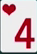

In [18]:
img_4h = Image.open("../../home/media/poker/4h.png")
img_4h

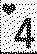

In [19]:
img_4_dither = img_4h.convert("1")
img_4_dither

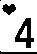

In [20]:
img_4 = img_4h.convert("1", dither=False)
img_4

In [41]:
def mse(im1, im2):
    im1 = np.array(im1).astype(int)
    im2 = np.array(im2).astype(int)
    err = np.sum((im1 - im2)**2)
    err /= float(im1.shape[0] * im2.shape[1])
    return err

In [42]:
mse(img_4_dither, img_4)

0.1031031031031031

In [29]:
rmsdiff(img_4_dither, img_4)

81.87966340477517

## SSIM

In [ ]:
!pip3 install scikit-image

In [43]:
from skimage.measure import structural_similarity as ssim
import matplotlib.pyplot as plt
import numpy as np
import cv2

ModuleNotFoundError: No module named 'skimage'

In [ ]:
def compare_images(imageA, imageB, title):
    # compute the mean squared error and structural similarity
    # index for the images
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB)
    # setup the figure
    fig = plt.figure(title)
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap=plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap=plt.cm.gray)
    plt.axis("off")
    # show the images
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim

img = img_as_float(data.camera())
rows, cols = img.shape

noise = np.ones_like(img) * 0.2 * (img.max() - img.min())
noise[np.random.random(size=noise.shape) > 0.5] *= -1


def mse(x, y):
    return np.linalg.norm(x - y)


img_noise = img + noise
img_const = img + abs(noise)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), sharex=True, sharey=True)
ax = axes.ravel()

mse_none = mse(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min())

mse_noise = mse(img, img_noise)
ssim_noise = ssim(img, img_noise, data_range=img_noise.max() - img_noise.min())

mse_const = mse(img, img_const)
ssim_const = ssim(img, img_const, data_range=img_const.max() - img_const.min())

label = 'MSE: {:.2f}, SSIM: {:.2f}'

ax[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[0].set_xlabel(label.format(mse_none, ssim_none))
ax[0].set_title('Original image')

ax[1].imshow(img_noise, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[1].set_xlabel(label.format(mse_noise, ssim_noise))
ax[1].set_title('Image with noise')

ax[2].imshow(img_const, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[2].set_xlabel(label.format(mse_const, ssim_const))
ax[2].set_title('Image plus constant')

plt.tight_layout()
plt.show()

## [skimage.util.compare_images](https://scikit-image.org/docs/dev/api/skimage.util.html#skimage.util.compare_images)

## [skimage.measure.compare_ssim](https://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=ssim#compare-ssim)

## [skimage.measure.compare_psnr](https://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=ssim#compare-psnr)

## [skimage.measure.compare_nrmse](https://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=ssim#compare-nrmse)

## [skimage.measure.compare_mse](https://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=ssim#compare-mse)

In [ ]:
import warnings
from skimage.measure import compare_ssim
from skimage.transform import resize
from scipy.stats import wasserstein_distance
from scipy.misc import imsave
from scipy.ndimage import imread
import numpy as np
import cv2

##
# Globals
##

warnings.filterwarnings('ignore')

# specify resized image sizes
height = 2**10
width = 2**10

##
# Functions
##


def get_img(path, norm_size=True, norm_exposure=False):
    '''
  Prepare an image for image processing tasks
  '''
    # flatten returns a 2d grayscale array
    img = imread(path, flatten=True).astype(int)
    # resizing returns float vals 0:255; convert to ints for downstream tasks
    if norm_size:
        img = resize(img, (height, width), anti_aliasing=True, preserve_range=True)
    if norm_exposure:
        img = normalize_exposure(img)
    return img


def get_histogram(img):
    '''
  Get the histogram of an image. For an 8-bit, grayscale image, the
  histogram will be a 256 unit vector in which the nth value indicates
  the percent of the pixels in the image with the given darkness level.
  The histogram's values sum to 1.
  '''
    h, w = img.shape
    hist = [0.0] * 256
    for i in range(h):
        for j in range(w):
            hist[img[i, j]] += 1
    return np.array(hist) / (h * w)


def normalize_exposure(img):
    '''
  Normalize the exposure of an image.
  '''
    img = img.astype(int)
    hist = get_histogram(img)
    # get the sum of vals accumulated by each position in hist
    cdf = np.array([sum(hist[:i + 1]) for i in range(len(hist))])
    # determine the normalization values for each unit of the cdf
    sk = np.uint8(255 * cdf)
    # normalize each position in the output image
    height, width = img.shape
    normalized = np.zeros_like(img)
    for i in range(0, height):
        for j in range(0, width):
            normalized[i, j] = sk[img[i, j]]
    return normalized.astype(int)


def earth_movers_distance(path_a, path_b):
    '''
  Measure the Earth Mover's distance between two images
  @args:
    {str} path_a: the path to an image file
    {str} path_b: the path to an image file
  @returns:
    TODO
  '''
    img_a = get_img(path_a, norm_exposure=True)
    img_b = get_img(path_b, norm_exposure=True)
    hist_a = get_histogram(img_a)
    hist_b = get_histogram(img_b)
    return wasserstein_distance(hist_a, hist_b)


def structural_sim(path_a, path_b):
    '''
  Measure the structural similarity between two images
  @args:
    {str} path_a: the path to an image file
    {str} path_b: the path to an image file
  @returns:
    {float} a float {-1:1} that measures structural similarity
      between the input images
  '''
    img_a = get_img(path_a)
    img_b = get_img(path_b)
    sim, diff = compare_ssim(img_a, img_b, full=True)
    return sim


def pixel_sim(path_a, path_b):
    '''
  Measure the pixel-level similarity between two images
  @args:
    {str} path_a: the path to an image file
    {str} path_b: the path to an image file
  @returns:
    {float} a float {-1:1} that measures structural similarity
      between the input images
  '''
    img_a = get_img(path_a, norm_exposure=True)
    img_b = get_img(path_b, norm_exposure=True)
    return np.sum(np.absolute(img_a - img_b)) / (height * width) / 255


def sift_sim(path_a, path_b):
    '''
  Use SIFT features to measure image similarity
  @args:
    {str} path_a: the path to an image file
    {str} path_b: the path to an image file
  @returns:
    TODO
  '''
    # initialize the sift feature detector
    orb = cv2.ORB_create()

    # get the images
    img_a = cv2.imread(path_a)
    img_b = cv2.imread(path_b)

    # find the keypoints and descriptors with SIFT
    kp_a, desc_a = orb.detectAndCompute(img_a, None)
    kp_b, desc_b = orb.detectAndCompute(img_b, None)

    # initialize the bruteforce matcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # match.distance is a float between {0:100} - lower means more similar
    matches = bf.match(desc_a, desc_b)
    similar_regions = [i for i in matches if i.distance < 70]
    if len(matches) == 0:
        return 0
    return len(similar_regions) / len(matches)


if __name__ == '__main__':
    img_a = 'a.jpg'
    img_b = 'b.jpg'
    # get the similarity values
    structural_sim = structural_sim(img_a, img_b)
    pixel_sim = pixel_sim(img_a, img_b)
    sift_sim = sift_sim(img_a, img_b)
    emd = earth_movers_distance(img_a, img_b)
    print(structural_sim, pixel_sim, sift_sim, emd)

## References

[Image Quality Assessment: From Error Visibility to Structural Similarity](https://www.cns.nyu.edu/pub/eero/wang03-reprint.pdf)

https://scikit-image.org/

https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html?highlight=ssim

https://scikit-image.org/docs/dev/api/skimage.measure.html

https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/

https://gist.github.com/duhaime/211365edaddf7ff89c0a36d9f3f7956c